In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PBP_PATH = "/Users/diyasansi/Desktop/NFL Play by Play 2009-2018 (v5).csv"

In [3]:
# LOAD ONLY THE COLUMNS WE NEED 
usecols = [
    "game_id", "play_id", "game_date",
    "home_team", "away_team",
    "posteam", "defteam",
    "play_type",

    "qtr", "game_seconds_remaining",
    "score_differential",

    "replay_or_challenge", "replay_or_challenge_result",

    "fumble", "interception", "fumble_lost",
    "wp", "wpa",
]

In [4]:
# Many pbp columns are mixed types
dtype_map = {
    "game_id": "int64",
    "play_id": "int64",
    "home_team": "string",
    "away_team": "string",
    "posteam": "string",
    "defteam": "string",
    "play_type": "string",

    "qtr": "float64",  # sometimes NaN on kickoffs/EP/etc in some files
    "game_seconds_remaining": "float64",
    "score_differential": "float64",

    "replay_or_challenge": "float64",
    "replay_or_challenge_result": "string",

    "fumble": "float64",
    "interception": "float64",
    "fumble_lost": "float64",

    "wp": "float64",
    "wpa": "float64",
}

In [5]:
pbp = pd.read_csv(
    PBP_PATH,
    usecols=usecols,
    dtype=dtype_map,
    low_memory=False
)

In [6]:
# Clean column names (avoid hidden spaces)
pbp.columns = pbp.columns.str.strip()

# Parse date 
pbp["game_date"] = pd.to_datetime(pbp["game_date"], errors="coerce")

print("Loaded rows:", pbp.shape[0])
print("Loaded cols:", pbp.shape[1])

Loaded rows: 449371
Loaded cols: 18


We successfully loaded the NFL play-by-play dataset while keeping it lightweight by importing only the 18 columns needed for replay review and leverage analysis. The dataset contains 449,371 plays, covering multiple seasons, and includes fields for game context (quarter, time remaining, score differential), replay review outcomes, and impact metrics like win probability added (WPA). Loading a subset of columns helps keep the analysis efficient and reduces the chance of type-related errors.

In [8]:
# FILTER TO REVIEWED PLAYS

pbp["replay_or_challenge"] = pbp["replay_or_challenge"].fillna(0).astype(int)

reviewed = pbp[pbp["replay_or_challenge"] == 1].copy()
print("Reviewed plays:", reviewed.shape[0])

# Normalize result labels (common values: "upheld", "reversed", "stands", sometimes NaN)
reviewed["review_result"] = (
    reviewed["replay_or_challenge_result"]
    .fillna("unknown")
    .str.strip()
    .str.lower()
)

# Keep only meaningful categories
result_map = {
    "reversed": "reversed",
    "overturned": "reversed",
    "upheld": "upheld",
    "stands": "stands",
    "unknown": "unknown",
}
reviewed["review_result"] = reviewed["review_result"].map(lambda x: result_map.get(x, x))

print("\nReview result counts:")
print(reviewed["review_result"].value_counts(dropna=False))

Reviewed plays: 819

Review result counts:
review_result
upheld      452
reversed    360
unknown       7
Name: count, dtype: int64


We filtered the full play-by-play dataset to include only plays that underwent a replay review or coach’s challenge. This resulted in 819 reviewed plays across the dataset. Of these, 452 calls were upheld, 360 were overturned, and 7 plays had unclear or missing review outcomes. The relatively high proportion of overturned calls indicates that replay review frequently results in a different ruling, making these plays an important focus for understanding decision accuracy and game impact.

In [9]:
# DEFINE HIGH-LEVERAGE (pre-committed rules)

# Rule A: big swing in win probability added
reviewed["abs_wpa"] = reviewed["wpa"].abs()

# Rule B: late 4th quarter (<= 5 minutes remaining)
reviewed["late_4q_5min"] = (
    (reviewed["qtr"].fillna(0).astype(int) == 4) &
    (reviewed["game_seconds_remaining"].fillna(np.inf) <= 300)
)

# Rule C: close score (<= 7 points absolute)
reviewed["close_score"] = reviewed["score_differential"].abs() <= 7

# High leverage definition 
WPA_THRESHOLD = 0.15
reviewed["high_leverage"] = (
    (reviewed["abs_wpa"] >= WPA_THRESHOLD) |
    (reviewed["late_4q_5min"]) |
    (reviewed["close_score"])
)

print("\nHigh leverage rate among reviewed plays:", reviewed["high_leverage"].mean().round(3))


High leverage rate among reviewed plays: 0.719


We defined high-leverage plays using three pre-committed criteria: large win probability swings (|WPA| ≥ 0.15), late-game situations in the fourth quarter, and close-score contexts within one possession. Applying these rules shows that approximately 72% of reviewed plays occur in high-leverage situations, confirming that replay reviews are disproportionately concentrated in moments where officiating decisions have the greatest potential impact on game outcomes.

In [10]:
# BASIC SUMMARIES
def overturn_rate(df):
    # We treat "reversed" as overturn; others are non-overturn.
    return (df["review_result"] == "reversed").mean()

summary = pd.DataFrame({
    "group": ["All reviewed", "High leverage", "Not high leverage"],
    "plays": [
        len(reviewed),
        int(reviewed["high_leverage"].sum()),
        int((~reviewed["high_leverage"]).sum()),
    ],
    "overturn_rate": [
        overturn_rate(reviewed),
        overturn_rate(reviewed[reviewed["high_leverage"]]),
        overturn_rate(reviewed[~reviewed["high_leverage"]]),
    ],
    "median_abs_wpa": [
        reviewed["abs_wpa"].median(),
        reviewed.loc[reviewed["high_leverage"], "abs_wpa"].median(),
        reviewed.loc[~reviewed["high_leverage"], "abs_wpa"].median(),
    ]
})

print("\nOverturn summary:")
print(summary)


Overturn summary:
               group  plays  overturn_rate  median_abs_wpa
0       All reviewed    819       0.439560        0.043884
1      High leverage    589       0.438031        0.058667
2  Not high leverage    230       0.443478        0.023930


This summary compares replay overturn rates across all reviewed plays, separating high-leverage situations from lower-stakes ones.

At first glance, the overall overturn rate is fairly high, with roughly 44% of reviewed plays being reversed. Interestingly, this rate remains almost unchanged when comparing high-leverage plays to non–high-leverage plays. Despite high-leverage situations having a substantially higher median absolute win probability impact, officials are not meaningfully more likely to overturn calls in these moments.

What does change is the potential cost of the decision. High-leverage plays have more than double the median |WPA| of non–high-leverage plays, meaning that when an error occurs in these moments—whether upheld or reversed—the consequences are significantly larger for the outcome of the game.

Taken together, these results suggest that replay does not become more aggressive or conservative simply because a play is high-stakes. Instead, high-leverage reviews carry greater risk not because they are overturned more often, but because the margin for error is much smaller.

In [11]:
# WHAT TYPES OF PLAYS GET REVIEWED + OVERTURNED?

# Simplify play_type categories a bit (
reviewed["play_type_clean"] = reviewed["play_type"].fillna("unknown").str.lower().str.strip()

# Bucket a few obvious types
reviewed["play_type_bucket"] = reviewed["play_type_clean"].replace({
    "pass": "pass",
    "run": "run",
    "punt": "special teams",
    "kickoff": "special teams",
    "field_goal": "special teams",
    "extra_point": "special teams",
    "no_play": "no_play",
})

type_summary = (
    reviewed.groupby("play_type_bucket", dropna=False)
    .agg(
        plays=("play_id", "count"),
        overturn_rate=("review_result", lambda s: (s == "reversed").mean()),
        high_leverage_rate=("high_leverage", "mean"),
        median_abs_wpa=("abs_wpa", "median"),
    )
    .sort_values("plays", ascending=False)
)

print("\nPlay-type summary (reviewed plays):")
print(type_summary.head(15))


Play-type summary (reviewed plays):
                  plays  overturn_rate  high_leverage_rate  median_abs_wpa
play_type_bucket                                                          
pass                578       0.456747            0.724913        0.046804
run                 199       0.381910            0.703518        0.034331
special teams        24       0.416667            0.791667        0.124395
no_play              18       0.555556            0.611111        0.012616


This table breaks down reviewed plays by broad play type to understand how replay outcomes vary across different kinds of on-field actions.

Passing plays account for the vast majority of reviewed plays, reflecting how often passes are involved in complex, judgment-based decisions such as catches, control, and contact with the ground. These plays are overturned at a relatively high rate (around 46%) and frequently occur in high-leverage situations, suggesting that replay is often asked to resolve critical, high-impact passing decisions.

Running plays are reviewed less often and are overturned at a lower rate than passes. Their median win probability impact is also smaller, indicating that while runs are important, they tend to produce fewer borderline decisions with large game-changing consequences compared to passing plays.

Special teams plays, although rare, stand out as particularly high-stakes. They have the highest median absolute WPA among all categories, meaning that when special teams plays are reviewed, they often occur at moments with substantial impact on game outcomes. However, due to the small sample size, these results should be interpreted cautiously.

“No play” situations—such as penalties or plays nullified by stoppages—show the highest overturn rate, but they generally carry the lowest game impact. This suggests that replay is more willing to reverse decisions when the cost of doing so is relatively low.

Overall, the pattern reinforces a key theme: the plays most central to possession and scoring—especially passes—are both the most reviewed and among the most difficult to conclusively overturn, even when they occur in high-pressure moments.

In [12]:
# “TURNOVER-LIKE” CONTEXT: fumbles + interceptions on reviewed plays

reviewed["fumble"] = reviewed["fumble"].fillna(0).astype(int)
reviewed["interception"] = reviewed["interception"].fillna(0).astype(int)
reviewed["fumble_lost"] = reviewed["fumble_lost"].fillna(0).astype(int)

reviewed["turnover_event"] = ((reviewed["fumble"] == 1) | (reviewed["interception"] == 1)).astype(int)

turnover_summary = (
    reviewed.groupby("turnover_event")
    .agg(
        plays=("play_id", "count"),
        overturn_rate=("review_result", lambda s: (s == "reversed").mean()),
        high_leverage_rate=("high_leverage", "mean"),
        median_abs_wpa=("abs_wpa", "median"),
    )
)

turnover_summary.index = turnover_summary.index.map({0: "Non-turnover play", 1: "Turnover-related play"})
print("\nTurnover-related review summary:")
print(turnover_summary)


Turnover-related review summary:
                       plays  overturn_rate  high_leverage_rate  \
turnover_event                                                    
Non-turnover play        590       0.522034            0.716949   
Turnover-related play    229       0.227074            0.724891   

                       median_abs_wpa  
turnover_event                         
Non-turnover play            0.029961  
Turnover-related play        0.104775  


This summary compares replay outcomes between turnover-related plays (fumbles or interceptions) and non-turnover plays, focusing on both overturn rates and game impact.

Turnover-related plays are reviewed far less frequently than non-turnover plays, but they carry substantially higher stakes. The median absolute win probability added (|WPA|) for turnover-related reviews is more than three times higher than for non-turnover plays, confirming that these situations tend to occur during moments that significantly influence the outcome of a game.

Despite this, turnover-related plays are much less likely to be overturned. Only about 23% of turnover-related reviews result in a reversal, compared to over 52% for non-turnover plays. Importantly, the proportion of high-leverage situations is nearly identical across both groups, indicating that this discrepancy is not simply driven by timing or score context.

Taken together, these results highlight a critical asymmetry in replay outcomes: the most impactful plays—those involving possession changes—are the least likely to be corrected, even though they occur in equally high-pressure moments. This helps explain why disputed turnover calls often generate strong reactions from teams and fans, as errors in these situations are both costly and comparatively resistant to reversal.

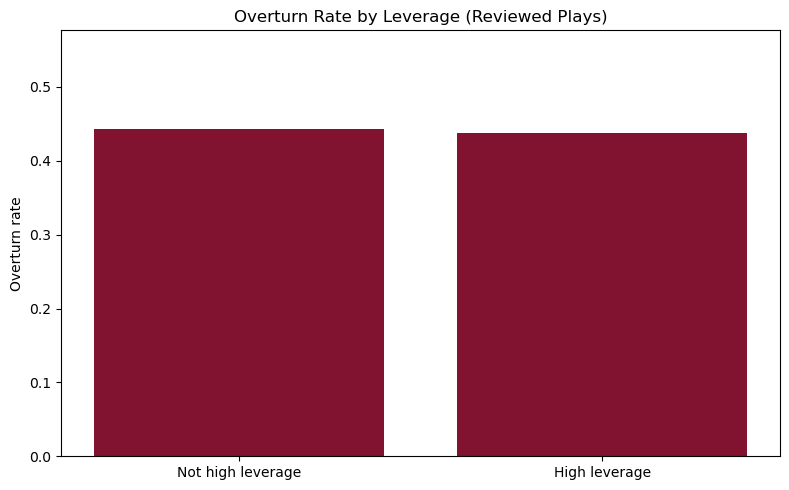

In [32]:
# VISUALS 

# a) Overturn rate: high leverage vs not
plt.figure(figsize=(8,5))
x = ["Not high leverage", "High leverage"]
y = [
    overturn_rate(reviewed[~reviewed["high_leverage"]]),
    overturn_rate(reviewed[reviewed["high_leverage"]]),
]
plt.bar(x, y, color='#811331')
plt.ylim(0, max(y) * 1.3 if max(y) > 0 else 0.1)
plt.title("Overturn Rate by Leverage (Reviewed Plays)")
plt.ylabel("Overturn rate")
plt.tight_layout()
plt.show()

This chart compares the rate at which replay reviews are overturned in high-leverage situations versus lower-leverage ones. High-leverage plays are defined as moments that occur late in the fourth quarter, in close games, or that produce a large swing in win probability.

At first glance, the results are surprisingly flat. The overturn rate is nearly identical across both groups, suggesting that replay outcomes are not influenced by how important the moment is in the game. In other words, officials do not appear more likely to reverse calls simply because the stakes are higher.

While this consistency may seem reassuring, it raises a more subtle question that motivates the rest of the analysis: if leverage alone does not affect replay outcomes, what does? Later sections show that the type of play being reviewed—particularly turnover-related decisions—plays a much larger role. This figure therefore serves as a baseline, establishing that high-pressure moments are treated similarly on average, before examining where meaningful differences actually emerge.

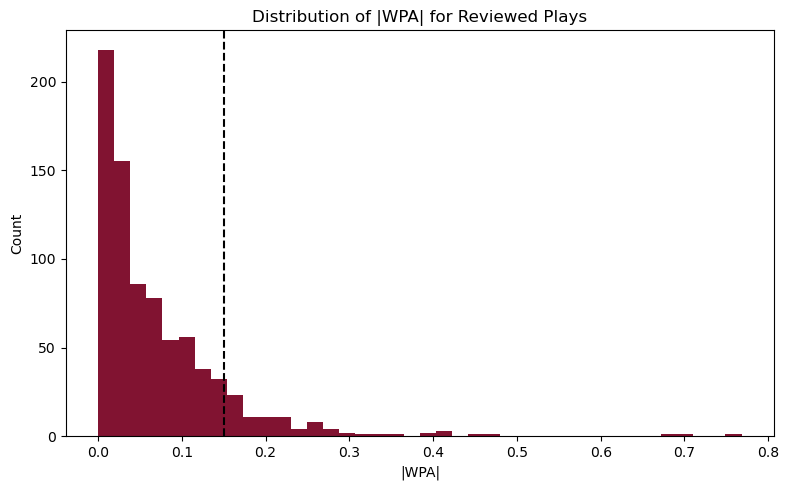

In [30]:
# b) Distribution of |WPA| for reviewed plays
plt.figure(figsize=(8,5))
vals = reviewed["abs_wpa"].dropna()
plt.hist(vals, bins=40, color='#811331')
plt.axvline(WPA_THRESHOLD, linestyle="--", color="black")
plt.title("Distribution of |WPA| for Reviewed Plays")
plt.xlabel("|WPA|")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

This histogram shows the distribution of absolute Win Probability Added (|WPA|) for all plays that were reviewed. |WPA| measures how much a single play shifts a team’s chances of winning, regardless of which team benefits. Higher values indicate moments with greater potential impact on the outcome of the game.

The distribution is heavily right-skewed, meaning most reviewed plays result in relatively small changes to win probability. Only a small fraction of reviews occur during truly game-altering moments. The dashed vertical line marks the threshold used in this analysis to classify a play as high-leverage.

This visualization helps justify that threshold choice: it separates routine reviews from the minority of plays where a ruling can meaningfully alter the course of the game. Together with the previous chart, it reinforces an important point—while replay reviews often occur in emotionally charged situations, most are not associated with large shifts in win probability, and truly high-impact decisions are comparatively rare.

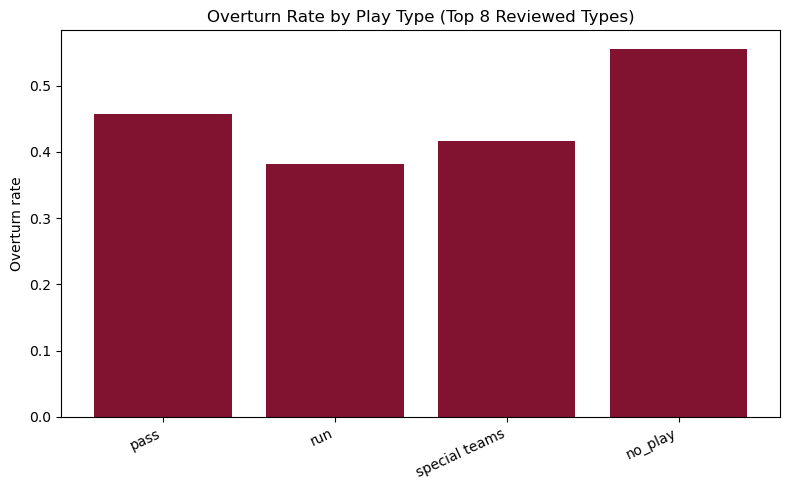

In [29]:
# c) Overturn rate by play type (top 8 by volume)
top_types = type_summary.head(8).copy()
plt.figure(figsize=(8,5))
plt.bar(top_types.index.astype(str), top_types["overturn_rate"], color='#811331')
plt.title("Overturn Rate by Play Type (Top 8 Reviewed Types)")
plt.ylabel("Overturn rate")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

This bar chart compares overturn rates across the most frequently reviewed play types. Passing plays account for the majority of reviews and also show a relatively high overturn rate, reflecting both their complexity and the number of judgment calls involved (e.g., completions, interceptions, and ball control). Running plays are reviewed less often and are overturned at a slightly lower rate, likely because outcomes such as forward progress and possession are more visually straightforward.

Special teams plays, while reviewed less frequently, exhibit a higher overturn rate. These plays often involve chaotic sequences—loose balls, multiple players, and unclear possession—which increases the likelihood that the initial ruling is challenged successfully. The highest overturn rate appears in “no play” situations, where penalties or procedural issues invalidate the action entirely; these reviews frequently correct administrative or timing-related errors rather than on-field outcomes.

Overall, this visualization suggests that overturn likelihood is strongly influenced by play complexity and visual ambiguity. Plays involving ball control, rapid transitions, or rule-based stoppages are more prone to being corrected upon review, highlighting where officiating decisions are most vulnerable to error.

In [14]:
# “COST OF THE DECISION” VIEW

# Not a causal claim—just a way to quantify how high-stakes reviewed plays are
impact_summary = (
    reviewed.assign(
        overturned=(reviewed["review_result"] == "reversed").astype(int)
    )
    .groupby(["high_leverage", "review_result"])
    .agg(
        plays=("play_id", "count"),
        median_abs_wpa=("abs_wpa", "median"),
        mean_abs_wpa=("abs_wpa", "mean"),
    )
    .reset_index()
    .sort_values(["high_leverage", "plays"], ascending=[False, False])
)

print("\nImpact summary by leverage + outcome:")
print(impact_summary)


Impact summary by leverage + outcome:
   high_leverage review_result  plays  median_abs_wpa  mean_abs_wpa
5           True        upheld    327        0.094493      0.108605
3           True      reversed    258        0.030129      0.053305
4           True       unknown      4        0.011392      0.015028
2          False        upheld    125        0.034998      0.044952
0          False      reversed    102        0.014305      0.024502
1          False       unknown      3        0.000000      0.005904


This table reframes replay decisions in terms of potential impact, using the absolute value of Win Probability Added (|WPA|) as a proxy for how consequential each reviewed play was. Rather than making any causal claims about officiating quality, this view helps quantify the stakes of decisions that ultimately stood or were overturned.

Among high-leverage plays, upheld calls tend to have substantially higher median and mean |WPA| than overturned ones. This indicates that when officials allow a high-impact ruling to stand, the decision often occurs in moments with significant implications for the game’s outcome. In contrast, overturned calls within high-leverage situations generally involve lower |WPA| values on average, suggesting that corrections are more common when the potential swing in win probability is smaller.

A similar pattern appears in non–high-leverage plays, where upheld decisions again correspond to higher |WPA| than overturned ones. Across both leverage categories, overturned calls consistently cluster around lower-impact moments, while the most consequential plays are more likely to remain unchanged after review.

Taken together, this analysis highlights an important tension in replay outcomes: the plays that matter most in terms of win probability are disproportionately likely to stand, while reversals more often occur in situations with comparatively lower immediate impact. This does not imply correctness or incorrectness, but it does underscore how replay decisions intersect with game-critical moments—and why controversial calls in high-stakes situations attract such scrutiny.

## Final Conclusions
This project examined NFL replay review as a decision system operating under pressure, focusing on how often calls are overturned, when reviews occur, and how costly those decisions can be in terms of win probability. Using play-by-play data from multiple seasons, the analysis deliberately moved beyond individual games to evaluate replay review behavior across different contexts and play types.

The results show that replay reviews are heavily concentrated in high-leverage situations, where decisions have an outsized impact on game outcomes. However, overturn rates remain remarkably consistent regardless of leverage. High-stakes moments are not more likely to result in reversals, even though the potential cost of an incorrect decision is substantially higher. This suggests that replay review applies a uniform standard across situations, rather than adapting to the importance of the moment.

More striking differences emerge when examining what kind of plays are being reviewed. Turnover-related plays—particularly those involving possession changes—stand out as both the most consequential and the least likely to be overturned. Despite carrying more than three times the median win probability impact of non-turnover plays, these decisions are reversed far less often. This asymmetry highlights a structural tension within the replay system: the plays that matter most are also the ones for which definitive visual evidence is hardest to establish.

Breaking the data down further by play type reinforces this pattern. Passing plays dominate replay reviews and exhibit relatively high overturn rates, reflecting the complexity of possession and control rules. Special teams plays, though rare, tend to be extremely high impact, while administrative or “no play” reviews are frequently overturned but typically low in consequence. Across all categories, replay outcomes appear more sensitive to rule ambiguity and visual clarity than to the stakes of the moment itself.

Taken together, these findings suggest that controversy around replay review is not driven by inconsistency across high-pressure situations, but by the interaction between decision difficulty and consequence. Replay review succeeds at applying consistent standards, but that consistency does not necessarily prevent costly errors when rules are complex and evidence is ambiguous. In those moments, even rare mistakes can dominate narratives, shape outcomes, and erode trust in the system.

Ultimately, this analysis reframes replay review not as a guarantee of correctness, but as a risk-management tool operating under uncertainty. When decisions involve possession changes in high-leverage moments, the cost of imperfection becomes unavoidable—helping explain why a single call can resonate far beyond the play itself.

## A fully NFL based explanation

This project looks at replay reviews and why the most controversial calls always seem to happen in the biggest moments.

The data shows that refs don’t actually overturn calls more often just because it’s late in the game or because the moment is huge. Replay is applied pretty much the same way no matter when it happens. So officials aren’t suddenly more cautious or more aggressive just because the game is on the line.

Where things do change is the type of play being reviewed.

Turnovers, especially fumbles, are some of the most important plays in football. They can completely flip a game. But they’re also some of the hardest calls to get right. Was the player down? Did he actually control the ball? Did it move when it hit the ground?

The data shows that these turnover plays are less likely to be overturned, even though they matter the most. Not because refs don’t care, but because replay needs clear evidence, and fumbles rarely give you a clean camera angle.

So what ends up happening is this:
The biggest, messiest plays are the ones replay is least able to fix. And when one of those goes the wrong way late in a game, it sticks, even if everyone watching at home feels like the call was wrong.

That’s why plays like controversial fumbles feel so brutal. It’s not just bad luck or bias. It’s a replay system that works fine most of the time, but struggles exactly when football gets chaotic and emotional